# Integrating snATAC-seq linked peak matrix
## human, macaque, and mouse caudate/caudoputamen

Notes on linked peaks notes: 
- intersecting human, macaque, and mouse peaks w/ reciprocal orthologs in these species
- call ties w/ multiple peak matches using nearest summits
- count matrix comes from linked peaks 1-1 in human and mouse 

Notes on integration:
- perform integration with about same number of cells in each group
    - here selected representative human and macaque subject
    - also using a guide tree in iterative merging
- predefine the features during anchor finding step

In [1]:
PROJDIR=file.path('../../../data/raw_data/cross_species_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=6.5)
suppressMessages(library(Signac)); suppressMessages(library(Seurat))

source('../hal_scripts/narrowPeakFunctions.R')
parallel::detectCores()

[1] 64

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("sequential")
options(future.globals.maxSize = 230 * 1024^3)

# 1) visualize unintegrated species clusters

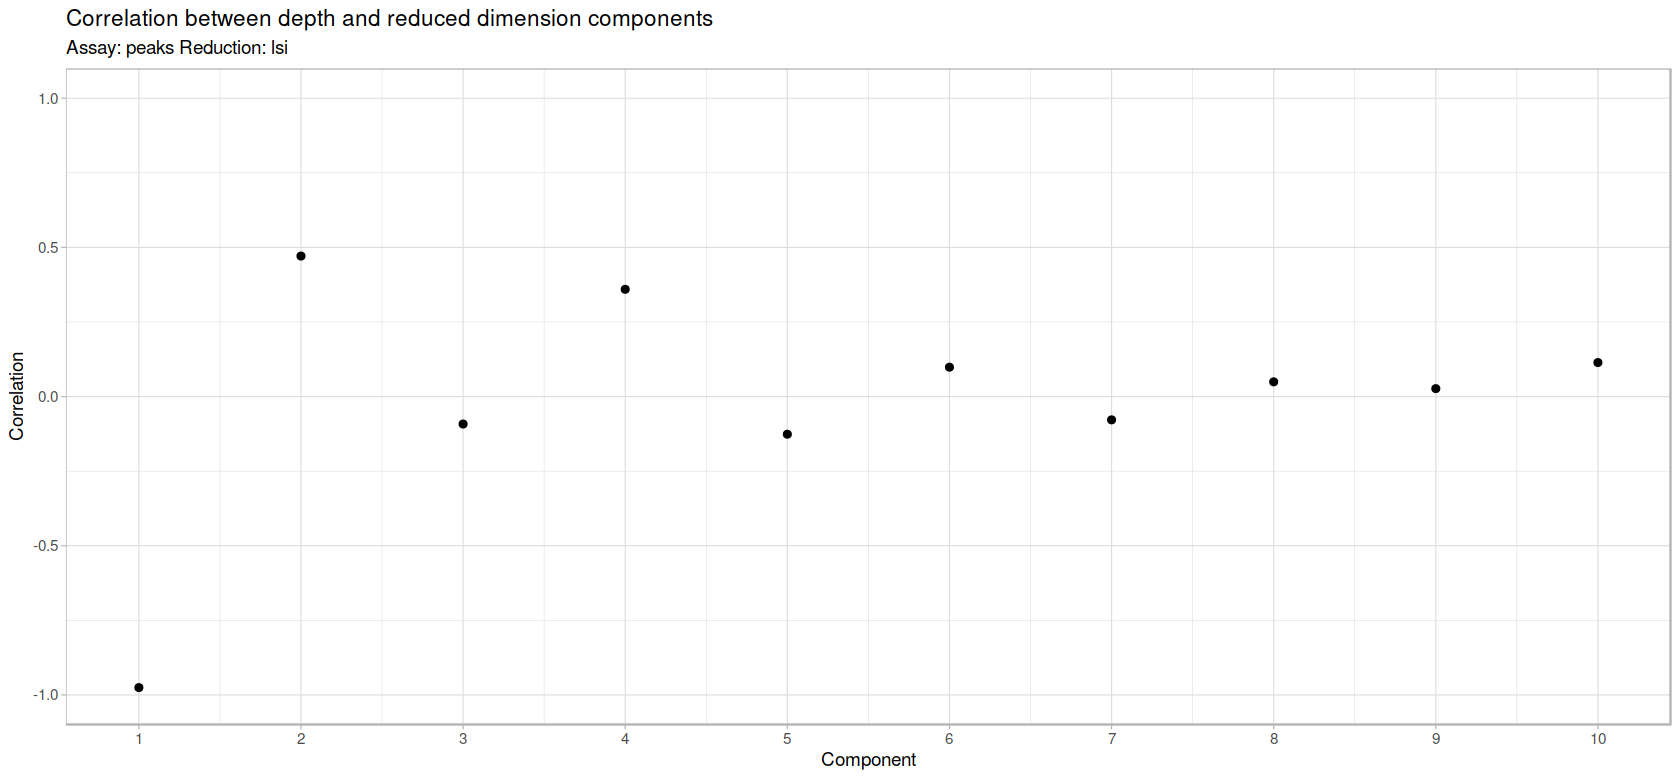

In [13]:
##
DepthCor(obj_seurat)

In [3]:
## load the seurat object
saveRDS_fn = file.path(PROJDIR, 'rdas', 'linkOrthologMatrixSeurat.rds')
obj_seurat = readRDS(file = saveRDS_fn)

##  TF-IDF, SVD, and UMAP already performed on 'peaks' matrix
obj_seurat

An object of class Seurat 
21749 features across 54473 samples within 1 assay 
Active assay: peaks (21749 features, 21749 variable features)
 2 dimensional reductions calculated: lsi, umap

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


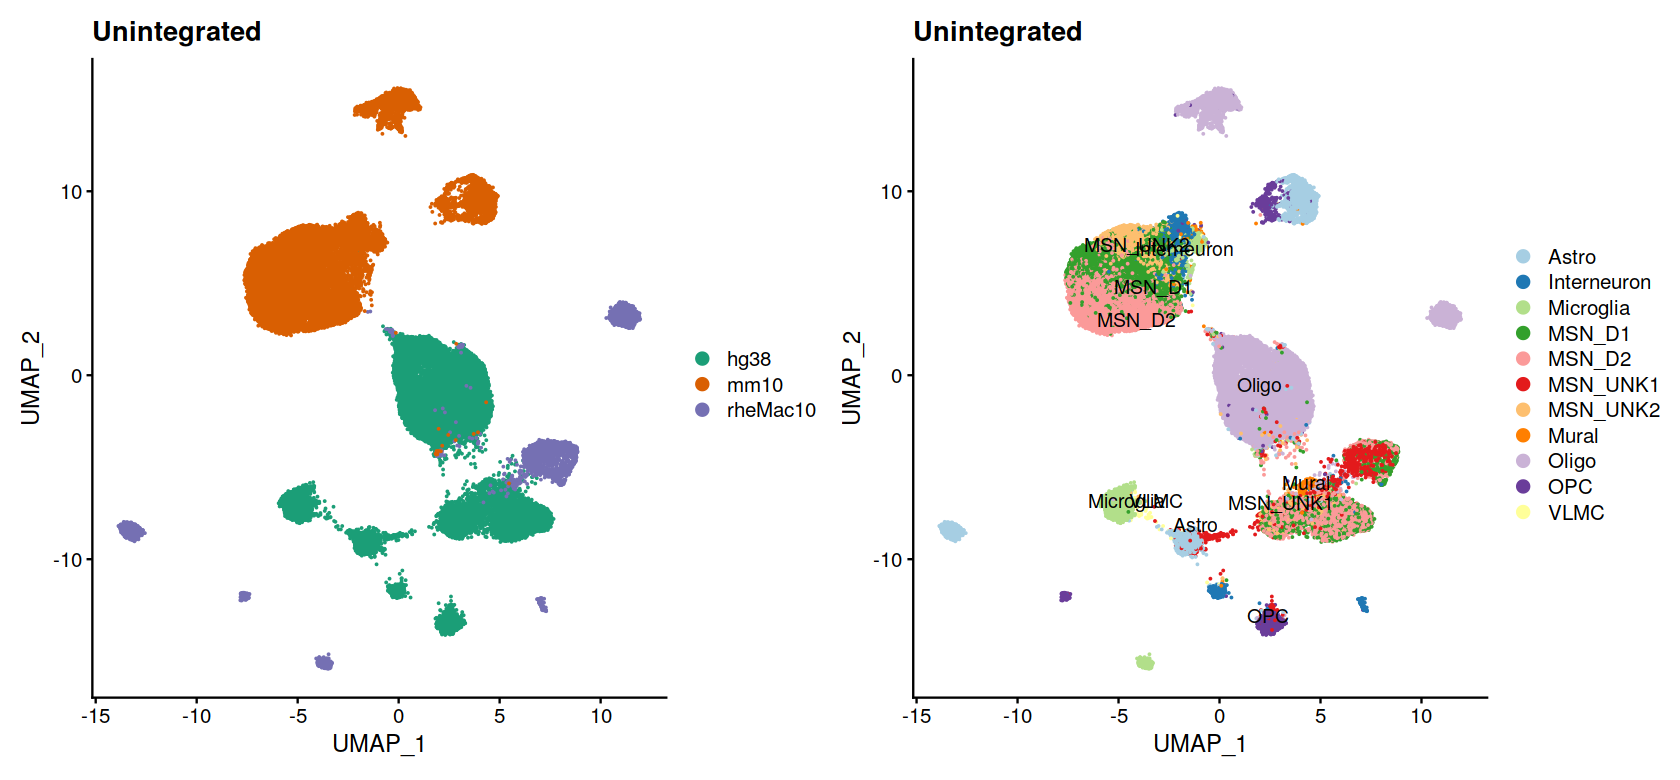

In [4]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Species', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_species + p_unintegrated_clusters2

# 2) integration with Seurat Intergration

In [5]:
## split seurat object up by species
obj_seurat.list = SplitObject(obj_seurat, split.by = 'Sample')
obj_seurat.list = lapply(obj_seurat.list, function(x){
  x <- RunTFIDF(x, verbose = FALSE)
  x <- FindTopFeatures(x, min.cutoff = 'q5')
})

# find integration anchors between species
features = rownames(obj_seurat)
# features <- SelectIntegrationFeatures(object.list = obj_seurat.list, nfeatures = 10000)

## compute SVD on all peaks
obj_seurat.list <- lapply(X = obj_seurat.list, FUN = function(x) {
    x <- RunSVD(x, features = features, verbose = FALSE)
})

##
names(obj_seurat.list)

[1] "09_1589.CAUD"         "14_1018.CAUD"         "06_0615.CAUD"        
[4] "CAUD_WS1H_STA682A131" "CEMBA180813_5E"       "CEMBA171219_4D"      
[7] "CEMBA171214_4D"       "CEMBA180820_5E"

In [6]:
# find integration anchors between species, using all features
anchors <- FindIntegrationAnchors(
        object.list = obj_seurat.list, reduction = 'cca', anchor.features = features,
        reference = c(2), # using 14_1018.CAUD as reference
        k.filter = NA, assay = rep('peaks', length(obj_seurat.list)))

gc()

Scaling features for provided objects

Finding anchors between all query and reference datasets

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21557 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23469 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 19284 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 22938 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20493 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20143 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21895 anchors



used       (Mb)    gc trigger (Mb)    max used   (Mb)   
Ncells   11101106   592.9   17062155   911.3   17062155   911.3
Vcells 1394163315 10636.7 3129949030 23879.7 3129949018 23879.7

In [7]:
# integrate data and create a new merged object
integrated <- IntegrateData(anchors, dims = 2:30, preserve.order = TRUE)

# we now have a "corrected" TF-IDF matrix, and can run LSI again on this corrected matrix
integrated <- RunSVD(integrated, n = 30, reduction.name = 'integratedLSI', verbose = FALSE)

Integrating dataset 1 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 3 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 4 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 5 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 6 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 7 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 8 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Adding a command log without an assay associated with it"
Warning message:
"The

# 3) compare integrated snATAC-seq cell types

In [11]:
integrated <- RunUMAP(integrated, dims = 3:30, reduction = 'integratedLSI', verbose = FALSE)

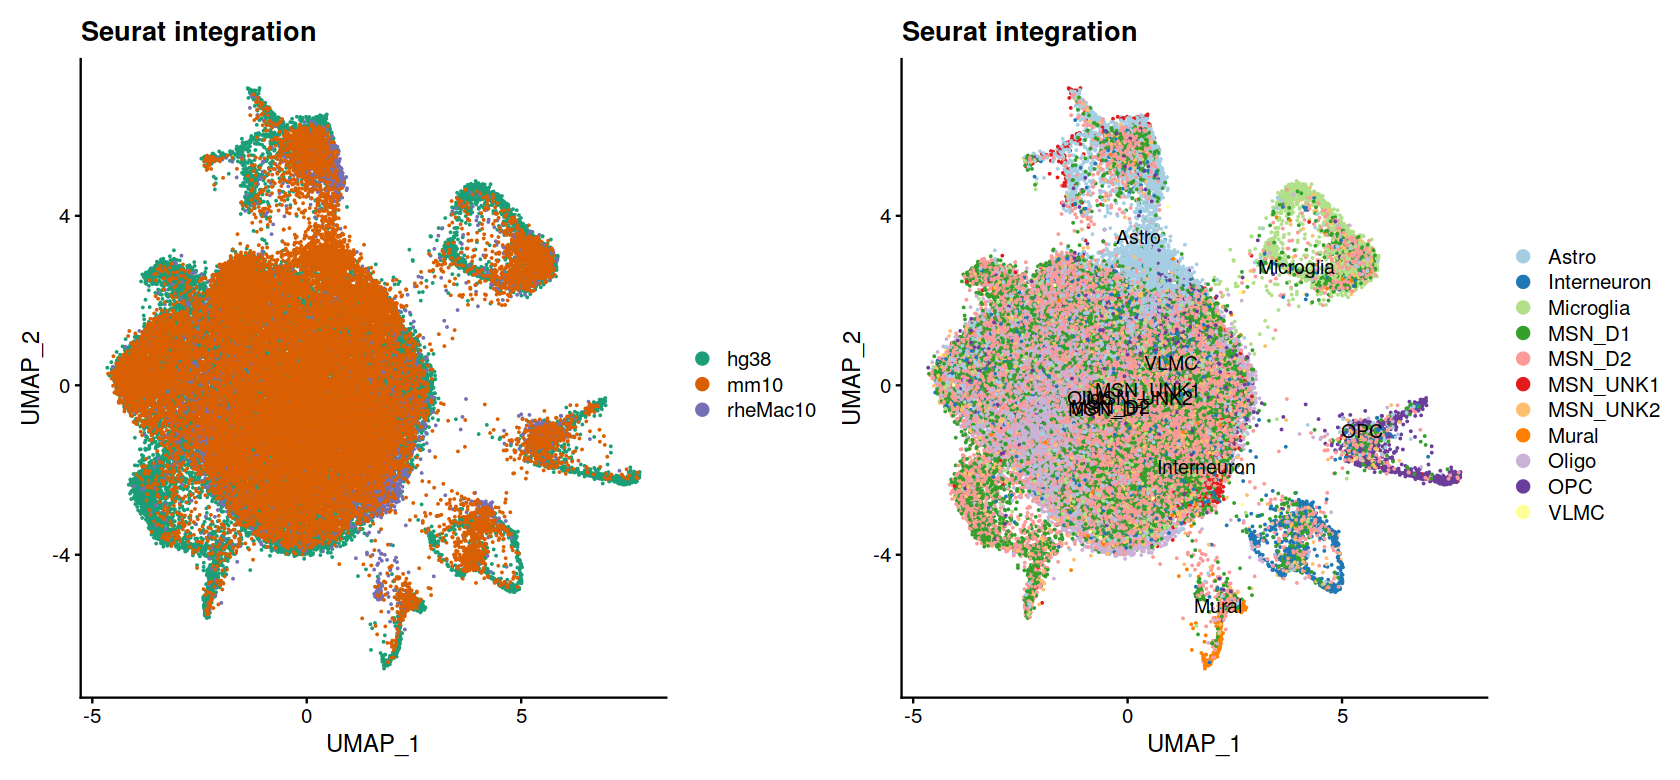

In [12]:
p_integrated_species = 
    DimPlot(object = integrated, label = FALSE, group.by = 'Species', cols = 'Dark2') +
    ggplot2::ggtitle("Seurat integration")

p_integrated_clusters2 = 
    DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
    ggplot2::ggtitle("Seurat integration")

p_integrated_species + p_integrated_clusters2

In [9]:
## save the seurat object
integratedRDS_fn = file.path(PROJDIR, 'rdas', 'linkOrthologSeuratCCA.rds')
system(paste('mkdir -p', dirname(integratedRDS_fn)))
saveRDS(integrated, file = integratedRDS_fn)

In [ ]:
gc()